In [1]:
import os

import numpy as np

from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService

from dotenv import load_dotenv
load_dotenv()

In [ ]:
# Exécuter la commande suivante une seule fois pour sauvegarder votre identifiant
QiskitRuntimeService.save_account(channel="ibm_quantum", token=os.getenv("TOKEN"))

In [5]:
# Vous pouvez également essayer l'instance ibm-q/open/main
service = QiskitRuntimeService(channel='ibm_quantum',
                               instance="pinq-quebec-hub/ecole-dt/main")
backends = service.backends()
backends

[<IBMBackend('ibm_quebec')>]

In [6]:
# On va travailler avec le processeur ibm_qc
qc_qc = backends[0]

In [34]:
# Circuit de la diapo 9
qc = QuantumCircuit(2)
qc.ry(2 * np.arccos(np.sqrt(0.65)), 0)
qc.x(0)
qc.cry(2 * np.arccos(np.sqrt(0.50/0.65)), 0, 1)
qc.x(0)
qc.cry(2 * np.arccos(np.sqrt(0.25/0.35)), 0, 1)

qc.draw(scale=0.7)

┌────────────┐┌───┐              ┌───┐              
q_0: ┤ Ry(1.2661) ├┤ X ├──────■───────┤ X ├──────■───────
     └────────────┘└───┘┌─────┴──────┐└───┘┌─────┴──────┐
q_1: ───────────────────┤ Ry(1.0022) ├─────┤ Ry(1.1279) ├
                        └────────────┘     └────────────┘

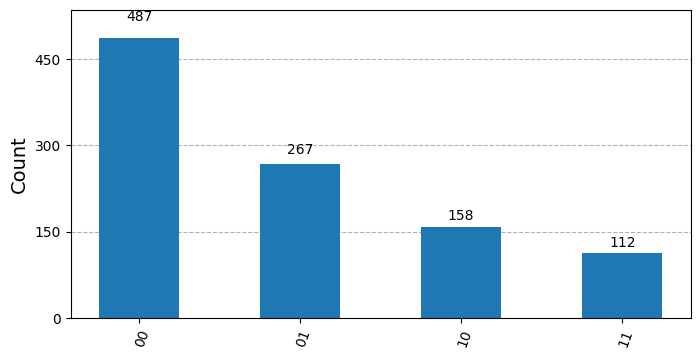

In [35]:
# Exécution du circuit avec le AerSimulator
simulator = AerSimulator()

qc_w_meas = qc.copy()
qc_w_meas.measure_all()

result = simulator.run(qc_w_meas).result()
plot_histogram(result.get_counts(qc), figsize=(8,4))

In [37]:
(result.get_counts(qc))

{'00': 487, '11': 112, '01': 267, '10': 158}

In [9]:
from qiskit.quantum_info import SparsePauliOp

# Une somme de chaînes de Pauli pondérées avec 3 termes
sum_paulis_1 = SparsePauliOp(data=['IZ', 'ZI', 'ZZ'],
                           coeffs=[0.1, 0.2, 0.3])

# Une somme de chaînes de Pauli avec 3 termes, par défaut coefficients = 1 
sum_paulis_2 = SparsePauliOp(data=['XX', 'YY', 'ZZ'])

print(sum_paulis_1)
print(sum_paulis_2)

SparsePauliOp(['IZ', 'ZI', 'ZZ'],
              coeffs=[0.1+0.j, 0.2+0.j, 0.3+0.j])
SparsePauliOp(['XX', 'YY', 'ZZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j])


In [10]:
# Les chaînes de Pauli peuvent être additionnées
sum_paulis = sum_paulis_1 + sum_paulis_2
print(sum_paulis)

# Puis simplifiées
sum_paulis = sum_paulis.simplify()
print(sum_paulis)

SparsePauliOp(['IZ', 'ZI', 'ZZ', 'XX', 'YY', 'ZZ'],
              coeffs=[0.1+0.j, 0.2+0.j, 0.3+0.j, 1. +0.j, 1. +0.j, 1. +0.j])
SparsePauliOp(['IZ', 'ZI', 'ZZ', 'XX', 'YY'],
              coeffs=[0.1+0.j, 0.2+0.j, 1.3+0.j, 1. +0.j, 1. +0.j])


In [11]:
# Chaîne de Ising
def get_ising_int(nb_qubits: int,
                  coupling: float,
                  transverse_field: float,
                  periodic: bool = True):

    operators = [("ZZ", [i, i + 1], coupling) for i in range(0, nb_qubits - 1)]
    operators += [("Z", [i], transverse_field) for i in range(0, nb_qubits)]

    if periodic:
        operators += [("ZZ", [0, nb_qubits - 1], coupling)]

    return SparsePauliOp.from_sparse_list(operators, num_qubits=nb_qubits)

ising_8_qubits = get_ising_int(nb_qubits=8, coupling=1.0, transverse_field=0.5, periodic=True)
print(ising_8_qubits)

SparsePauliOp(['IIIIIIZZ', 'IIIIIZZI', 'IIIIZZII', 'IIIZZIII', 'IIZZIIII', 'IZZIIIII', 'ZZIIIIII', 'IIIIIIIZ', 'IIIIIIZI', 'IIIIIZII', 'IIIIZIII', 'IIIZIIII', 'IIZIIIII', 'IZIIIIII', 'ZIIIIIII', 'ZIIIIIIZ'],
              coeffs=[1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j, 0.5+0.j,
 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 1. +0.j])


In [12]:
# Implémentations de BaseSamplerV2
from qiskit.primitives import StatevectorSampler
from qiskit.primitives import BackendSamplerV2
from qiskit_aer.primitives import SamplerV2 as AerSampler
from qiskit_ibm_runtime import SamplerV2 as RuntimeSampler

In [13]:
# Implémentations de BaseEstimatorV2
from qiskit.primitives import StatevectorEstimator
from qiskit.primitives import BackendEstimatorV2
from qiskit_aer.primitives import EstimatorV2 as AerEstimator
from qiskit_ibm_runtime import EstimatorV2 as RuntimeEstimator

In [14]:
# Sampler basé sur la simulation du vecteur d'états
sampler = StatevectorSampler()

# Calcul des valeurs moyennes
pubs = [(qc_w_meas)]
job = sampler.run(pubs, shots=256)  # pas de transpilation car sur simulateur

# Récupération du résultat de la tâche
results = job.result()

# Dictionnaire de counts
print(results[0].data.meas.get_counts())

{'00': 126, '01': 63, '11': 26, '10': 41}


In [16]:
# Estimator basé sur la simulation du vecteur d'états
estimator = StatevectorEstimator()

# Exécution du circuit
pubs = [(qc, sum_paulis)]  # note: on prend le circuit sans mesure
job = estimator.run(pubs)  # pas de transpilation car sur simulateur

# Récupération du résultat de la tâche
results = job.result()

# Valeurs moyennes
print(results[0].data.evs)

1.1645966692414835


In [17]:
from qiskit.circuit import Parameter

# Exemple avec un circuit paramétré
circuit = QuantumCircuit(3)
circuit.h(0)
circuit.cx(0, 1)
circuit.cx(1, 2)
circuit.ry(Parameter("a"), 0)
circuit.rz(Parameter("b"), 0)
circuit.cx(1, 2)
circuit.cx(0, 1)
circuit.h(0)
circuit.measure_all()

circuit.draw(scale=0.7)

┌───┐     ┌───────┐┌───────┐     ┌───┐ ░ ┌─┐      
   q_0: ┤ H ├──■──┤ Ry(a) ├┤ Rz(b) ├──■──┤ H ├─░─┤M├──────
        └───┘┌─┴─┐└───────┘└───────┘┌─┴─┐└───┘ ░ └╥┘┌─┐   
   q_1: ─────┤ X ├────■────────■────┤ X ├──────░──╫─┤M├───
             └───┘  ┌─┴─┐    ┌─┴─┐  └───┘      ░  ║ └╥┘┌─┐
   q_2: ────────────┤ X ├────┤ X ├─────────────░──╫──╫─┤M├
                    └───┘    └───┘             ░  ║  ║ └╥┘
meas: 3/══════════════════════════════════════════╩══╩══╩═
                                                  0  1  2

In [18]:
# Échantillonner le vecteur d'états pour 2 ensembles de paramètres
pubs = [(circuit, {'a':np.pi / 20, 'b':np.pi / 10}),
        (circuit, {'a':np.pi / 10, 'b':np.pi / 5})]
job = sampler.run(pubs, shots=256)

results = job.result()

# On a passé 2 PUBs en entrée, il y a 2 objets Result en sortie
for r in results:
    print(r.data.meas.get_counts())

{'000': 247, '001': 6, '011': 3}
{'001': 21, '000': 230, '011': 5}


In [19]:
from qiskit import transpile

qc_w_meas_qc = transpile(qc_w_meas, qc_qc)

# Dé-commenter la ligne suivante pour voir le circuit avec 127 qubits
qc_w_meas_qc.draw()

global phase: π
                                                                           »
    ancilla_0 -> 0 ────────────────────────────────────────────────────────»
                                                                           »
    ancilla_1 -> 1 ────────────────────────────────────────────────────────»
                                                                           »
    ancilla_2 -> 2 ────────────────────────────────────────────────────────»
                                                                           »
    ancilla_3 -> 3 ────────────────────────────────────────────────────────»
                                                                           »
    ancilla_4 -> 4 ────────────────────────────────────────────────────────»
                                                                           »
    ancilla_5 -> 5 ────────────────────────────────────────────────────────»
                                                                           »
    ancilla_6 -> 6 ────────────────────────────────────────────────────────»
                                                                           »
    ancilla_7 -> 7 ────────────────────────────────────────────────────────»
                                                                           »
    ancilla_8 -> 8 ────────────────────────────────────────────────────────»
                                                                           »
    ancilla_9 -> 9 ────────────────────────────────────────────────────────»
                                                                           »
  ancilla_10 -> 10 ────────────────────────────────────────────────────────»
                                                                           »
  ancilla_11 -> 11 ────────────────────────────────────────────────────────»
                                                                           »
  ancilla_12 -> 12 ────────────────────────────────────────────────────────»
                                                                           »
  ancilla_13 -> 13 ────────────────────────────────────────────────────────»
                                                                           »
  ancilla_14 -> 14 ────────────────────────────────────────────────────────»
                                                                           »
  ancilla_15 -> 15 ────────────────────────────────────────────────────────»
                                                                           »
  ancilla_16 -> 16 ────────────────────────────────────────────────────────»
                                                                           »
  ancilla_17 -> 17 ────────────────────────────────────────────────────────»
                                                                           »
  ancilla_18 -> 18 ────────────────────────────────────────────────────────»
                                                                           »
  ancilla_19 -> 19 ────────────────────────────────────────────────────────»
                                                                           »
  ancilla_20 -> 20 ────────────────────────────────────────────────────────»
                                                                           »
  ancilla_21 -> 21 ────────────────────────────────────────────────────────»
                                                                           »
  ancilla_22 -> 22 ────────────────────────────────────────────────────────»
                                                                           »
  ancilla_23 -> 23 ────────────────────────────────────────────────────────»
                                                                           »
  ancilla_24 -> 24 ────────────────────────────────────────────────────────»
                                                                           »
  ancilla_25 -> 25 ──────────────────────────────────────

In [20]:
# Exécuter sur ibm_quebec
sampler_qc = RuntimeSampler(mode=qc_qc)

pubs = [(qc_w_meas_qc)]
job = sampler_qc.run(pubs, shots=256)

# Récupération du résultat de la tâche
results = job.result()

# Dictionnaire de counts
print(results[0].data.meas.get_counts())

{'00': 125, '11': 28, '01': 71, '10': 32}


In [21]:
from qiskit.transpiler import generate_preset_pass_manager

# Instancier le PassManager par défaut
pm = generate_preset_pass_manager(optimization_level=1, backend=qc_qc)

pubs = []
isa_circuit = pm.run(qc)

# D'un observable qui est une somme de 5 chaînes de Pauli, on
# passe à 5 observables comptant chacun 1 chaîne de Pauli 
isa_obs = [o.apply_layout(isa_circuit.layout) for o in sum_paulis]
pubs.append((isa_circuit, isa_obs))

In [22]:
estimator = RuntimeEstimator(mode=qc_qc)
runtimejob = estimator.run(pubs=pubs)

In [25]:
runtimejob.status()

'RUNNING'

In [26]:
result = runtimejob.result()
result[0].data.evs

array([ 0.03121357,  0.10336487,  0.29663837,  0.78071307, -0.07443124])